# Unsupervised anomaly detection in the MNIST dataset using simple Autoencoders

The goal here is to generate some simple anomalies in the MNIST dataset and design an autoencoder (AE) which is capable of detecting and segmenting the errors introduced in the digits images.

In [1]:
%matplotlib inline
%gui qt5

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

2.2.0


### Dataset

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Utility functions to generate and plot anomalies

In [5]:
# mount google drive: follow the link, choose the account that contains the dataset and paste token in the displayed field
# from google.colab import drive
# import os
# import sys

# drive_folder = "BACMMAN_DISTNET/UAD/MNIST/"

# def mount_drive():
#   drive.mount('/content/driveDL', force_remount=True)
#   os.chdir("/content/driveDL/My Drive/"+drive_folder)
# mount_drive()

In [6]:
from MNIST_anomalies import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies
from MNIST_anomalies import plot_predictions

<Figure size 432x288 with 0 Axes>

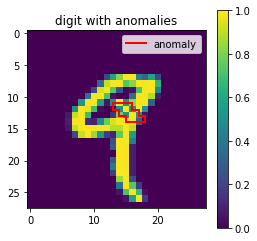

In [7]:
plt.viridis()

idx = 4

norm = x_train[idx].reshape((28, 28))
anom = set_anomaly(norm)

maskimg = np.abs(anom - norm) > 0

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

plt.imshow(anom)
contour_anomalies(ax, maskimg)
plt.title("digit with anomalies")
plt.colorbar()

# 1. The simple autoencoder

In [ ]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = layers.Input(shape=(input_size,))
hidden_1 = layers.Dense(hidden_size, activation='relu')(input_img)
code = layers.Dense(code_size, activation='relu')(hidden_1)
hidden_2 = layers.Dense(hidden_size, activation='relu')(code)
output_img = layers.Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1375
Epoch 2/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0986
Epoch 3/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0930


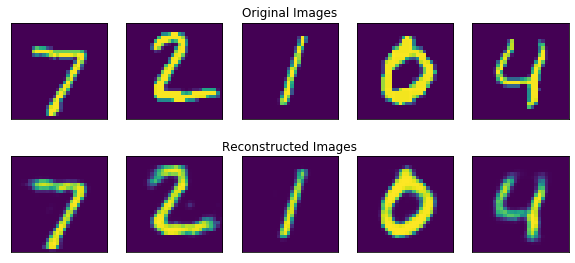

In [ ]:
plot_predictions(autoencoder, x_test, 5, dims=(784,))

In [ ]:
pred, anomalies, anomalies_pred = predict_anomalies(autoencoder, x_test, dims=(784,))

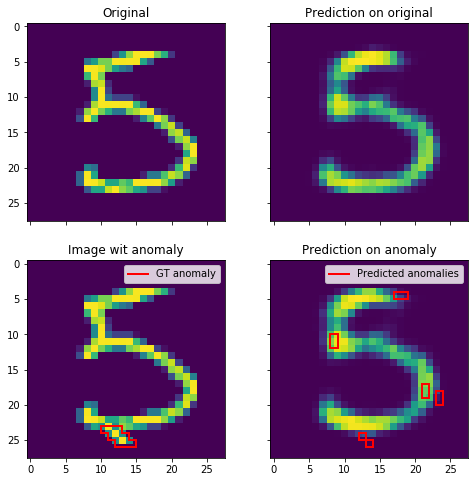

In [ ]:
plot_anomalies(x_test, pred, anomalies, anomalies_pred, show_idx=15, threshold=0.7)

In [ ]:
# Visualizing with napari

# from napari.utils import nbscreenshot

# show_idx = 15

# from skimage import data
# import napari

# with napari.gui_qt():
#     viewer = napari.view_image(x_test[show_idx].reshape((28, 28)), name="original")
    
#     viewer.add_image(pred[show_idx].reshape((28, 28)), name="prediction")
    
#     viewer.add_image(anomalies[show_idx].reshape((28, 28)), name="anomaly")
#     viewer.add_labels(true_anomaly.reshape((28,28)), name="segmented anomaly")
    
#     viewer.add_image(anomalies_pred[show_idx].reshape((28, 28)), name="anomaly prediction")
#     viewer.add_labels(predicted_anomaly.reshape((28,28)), name="predicted anomaly")

# #     viewer.grid_view()

# nbscreenshot(viewer, canvas_only=True)
    

Thus we show that with a simple encoder architecture, we are able to detect and segment anomalies on new examples, to some extent. The threshold has to be chosen according to a trade-off between getting all the anormal pixels (even those with low intensity) and getting a lot of false positives. Next, we wille check with an autoencoder architecture if we can improve the performances.

# 2. Convolutional Autoencoder

Here we adapt the UNet architecture to our problem : we suppress the skip connections and keep the convolutional encoder-decoder structure.

To begin we use a reduced UNet architecture, with only two convolution-pooling blocks of two layers in the coder and in the encoder, instead of for blocks for each in the original architecture. The number of filters was also reduced by 16.

In [1]:
# short U-Net version

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # second layer
    x = layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x

inputs = Input(shape=(28, 28, 1))
n_filters = 4
batchnorm = True
dropout = 0.1
  
# Contracting Path
c1 = conv2d_block(inputs, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
p1 = MaxPooling2D((2, 2))(c1)
p1 = Dropout(dropout)(p1)

c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
p2 = MaxPooling2D((2, 2))(c2)
p2 = Dropout(dropout)(p2)

c5 = conv2d_block(p2, n_filters = n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c5)
u8 = Dropout(dropout)(u8)
c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
u9 = Dropout(dropout)(u9)
c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

cae = Model(inputs, outputs)

NameError: name 'Input' is not defined

In [ ]:
x_train_reshaped = np.array([x.reshape((28, 28, 1)) for x in x_train])
cae.compile(optimizer='adam', loss='binary_crossentropy')
cae.fit(x_train_reshaped, x_train_reshaped, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 99s 2ms/step - loss: 0.4307
Epoch 2/5
60000/60000 [==============================] - 99s 2ms/step - loss: 0.1951
Epoch 3/5
60000/60000 [==============================] - 100s 2ms/step - loss: 0.1321
Epoch 4/5
60000/60000 [==============================] - 100s 2ms/step - loss: 0.1090
Epoch 5/5
60000/60000 [==============================] - 101s 2ms/step - loss: 0.0993


(28, 28)
(28, 28)


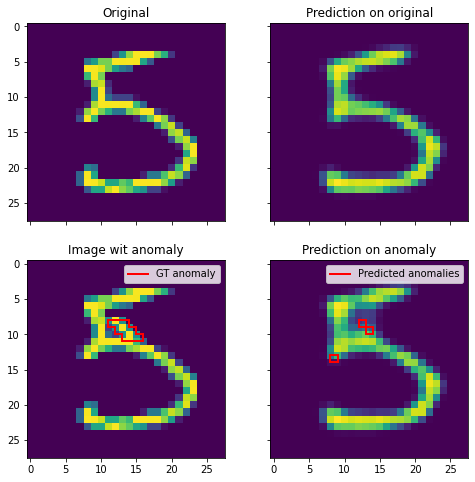

In [ ]:
plot_anomalies(cae, show_idx=15)

We see that the convolutional autoencoder outperforms the standard one, with a better segmentation of the identified anomaly (at constant threshold).